### Pre-process Pipeline

In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np


# These are length cols so their values must be 0 or +ve
cols_non_negative = ['tcp_time_delta', 'tcp_len', 'mqtt_len', 'mqtt_proto_len', 'mqtt_willmsg_len', 'mqtt_willtopic_len']

# nominal_cols = ['tcp_flags', 'mqtt_conack_flags', 'mqtt_conflags', 'mqtt_hdrflags']
# The other 2 are not useful --> (for more than 99% of the entries, they are 0)
# mqtt_hdrflags --> 37% of the entries are not in hex format but we will 1 hot encode it
nominal_cols = ['tcp_flags', 'mqtt_hdrflags']

continous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp',\
                'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_qos', 'mqtt_conflag_reserved', \
                'mqtt_conflag_retain', 'mqtt_conflag_uname', 'mqtt_conflag_willflag', 'mqtt_dupflag', \
                'mqtt_kalive', 'mqtt_len', 'mqtt_msg', 'mqtt_msgid', 'mqtt_msgtype', 'mqtt_proto_len', \
                'mqtt_qos', 'mqtt_retain', 'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_willmsg', \
                'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len', 'mqtt_ver', 'mqtt_conack_val']

def convert_string(s):
    return 0 if s == '0' else 1

def convert_target_to_label(target):
    if target == 'slowite':
        return 0
    elif target == 'bruteforce':
        return 1
    elif target == 'flood':
        return 2
    elif target == 'malformed':
        return 3
    elif target == 'dos':
        return 4
    elif target == 'legitimate':
        return 5
    else:
        return 6
    
class RenameDatasetCols(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        all_cols = output_df.columns
        for column in all_cols:
            new_column = column.replace('.', '_')
            output_df = output_df.withColumnRenamed(column, new_column)
        # print(output_df.columns)
        return output_df

class OutcomeCreator(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_classes = udf(convert_target_to_label, IntegerType())
        output_df = dataset.withColumn('label', label_to_classes(dataset['target'])).drop('target')
        output_df = output_df.withColumn('label', output_df['label'].cast(DoubleType()))
        return output_df
    
class ConstraintChecker(Transformer):
    def __init__(self, columns_to_check = None):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in cols_non_negative:
            output_df = output_df.filter(output_df[col_name] >= 0)
        return output_df
    
class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            if col_name in output_df.columns:
                output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_pipeline():

    # Stage where we rename the columns
    stage_column_renamer = RenameDatasetCols()

    # Stage where we handle nominal values
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continous_cols + nominal_onehot_cols

    # These cols have only 1 unique value
    cols_single_val = ['mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conflag_qos', \
                       'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_willflag', 'mqtt_sub_qos', \
                        'mqtt_suback_qos', 'mqtt_willmsg', 'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len']
    
    # Highly correlaterd columns
    cols_high_corr = ['mqtt_conflag_cleansess', 'mqtt_proto_len', 'mqtt_conflag_passwd', 'mqtt_len']
    
    # Not useful columns
    cols_not_useful = ['mqtt_msg']

    # These are supposed to be in form 0x0000XX but > 99% are 0
    cols_hex_constraints_not_met = ['mqtt_conack_flags', 'mqtt_conflags']

    # > 99% of the entries are 0
    cols_more_than_99_zero = ['mqtt_conack_val', 'mqtt_conflag_uname', 'mqtt_kalive', 'mqtt_protoname', 'mqtt_retain', 'mqtt_ver']
    
    cols_to_remove = cols_single_val + cols_high_corr + cols_not_useful + cols_hex_constraints_not_met + nominal_cols\
                     + nominal_id_cols + cols_more_than_99_zero
    
    for col_name in cols_to_remove:
        if col_name in feature_cols:
            feature_cols.remove(col_name)

    print(feature_cols)
    # Stage where we assemble all the features into a vector

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='vectorized_features')

    # Stage where we scale the features
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage where we create the label column
    stage_label_creator = OutcomeCreator()

    # Removing all unnecessary columns, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = continous_cols + ['vectorized_features'] + nominal_cols\
                                         + nominal_id_cols + nominal_onehot_cols + cols_to_remove)

    # Connecting the columns into a pipeline
    pipeline = Pipeline(stages = [stage_column_renamer, stage_nominal_indexer,\
                                   stage_nominal_onehot_encoder, stage_vector_assembler, stage_scaler,\
                                      stage_label_creator, stage_column_dropper])
    
    return pipeline    


In [2]:
# Uncomment the following lines if you are using Windows!
# import findspark
# findspark.init()
# findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "yarn"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)\
    .set('spark.jars', 'gs://dataproc-staging-us-central1-159964990471-2n8oqiw8/postgresql-42.6.0.jar')

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

mqtt_train_raw = spark.read.csv("gs://dataproc-staging-us-central1-159964990471-2n8oqiw8/train70_reduced.csv" ,header=True, inferSchema= True)
mqtt_test_raw = spark.read.csv("gs://dataproc-staging-us-central1-159964990471-2n8oqiw8/test30_reduced.csv", header=True, inferSchema=True)

# preprocess_pipeline = get_preprocess_pipeline()
# preprocess_pipeline_model = preprocess_pipeline.fit(mqtt_train_raw)

# mqtt_train_df = preprocess_pipeline_model.transform(mqtt_train_raw)
# mqtt_test_df = preprocess_pipeline_model.transform(mqtt_test_raw)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 19:18:22 INFO SparkEnv: Registering MapOutputTracker
23/11/16 19:18:22 INFO SparkEnv: Registering BlockManagerMaster
23/11/16 19:18:22 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/16 19:18:23 INFO SparkEnv: Registering OutputCommitCoordinator
/usr/lib/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
from pyspark.sql.functions import lit

mqtt_train_raw = mqtt_train_raw.withColumn('Train', lit(1))
mqtt_test_raw = mqtt_test_raw.withColumn('Train', lit(0))

### Loading data from postgres on cloud

In [4]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="18763kebjeseaya"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://34.136.81.58/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt"


mqtt_train_raw.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

mqtt_test_raw.write.format("jdbc")\
.mode("append")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

23/11/16 19:18:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
df = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df.show(1, vertical=True)

-RECORD 0--------------------------------
 tcp.flags                  | 0x00000018 
 tcp.time_delta             | 0.998867   
 tcp.len                    | 10         
 mqtt.conack.flags          | 0          
 mqtt.conack.flags.reserved | 0.0        
 mqtt.conack.flags.sp       | 0.0        
 mqtt.conack.val            | 0.0        
 mqtt.conflag.cleansess     | 0.0        
 mqtt.conflag.passwd        | 0.0        
 mqtt.conflag.qos           | 0.0        
 mqtt.conflag.reserved      | 0.0        
 mqtt.conflag.retain        | 0.0        
 mqtt.conflag.uname         | 0.0        
 mqtt.conflag.willflag      | 0.0        
 mqtt.conflags              | 0          
 mqtt.dupflag               | 0.0        
 mqtt.hdrflags              | 0x00000030 
 mqtt.kalive                | 0.0        
 mqtt.len                   | 8.0        
 mqtt.msg                   | 32         
 mqtt.msgid                 | 0.0        
 mqtt.msgtype               | 3.0        
 mqtt.proto_len             | 0.0 

### Passing through Pipeline

In [6]:
mqtt_train_raw = df.filter(df.Train == 1)
mqtt_test_raw = df.filter(df.Train == 0)

#dropping the train column
mqtt_train_raw = mqtt_train_raw.drop('Train')
mqtt_test_raw = mqtt_test_raw.drop('Train')

In [7]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(mqtt_train_raw)

mqtt_train_df = preprocess_pipeline_model.transform(mqtt_train_raw)
mqtt_test_df = preprocess_pipeline_model.transform(mqtt_test_raw)

['tcp_time_delta', 'tcp_len', 'mqtt_dupflag', 'mqtt_msgid', 'mqtt_msgtype', 'mqtt_qos', 'tcp_flags_encoded', 'mqtt_hdrflags_encoded']


In [8]:
print(mqtt_train_df.count())
print(mqtt_test_df.count())
# to find how many records of each label are there

mqtt_train_df.groupBy('label').count().orderBy("label").show()

231646
99290


+-----+------+
|label| count|
+-----+------+
|  0.0|  6441|
|  1.0| 10150|
|  2.0|   429|
|  3.0|  7646|
|  4.0| 91156|
|  5.0|115824|
+-----+------+



### Spark Models

In [9]:
class_names=[0,1,2,3,4,5]
class_names_str=["slowite","bruteforce", "flood", "malformed", "dos", "legitimate"]

# plot a confusion matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def plot_confusion_matrix(cm, classes = class_names_str,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Input the model, the dataframe, the classes, and the title of the plot.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def model_performance(model, df_train, df_test = None, model_name = None):
    """
    This function prints the accuracy and confusion matrix of the model on the training and test set.
    Input the model, the dataframe(s).

    """
    # Training accuracy
    pred_train = model.transform(df_train)
    acc_train = pred_train.filter(pred_train.label == pred_train.prediction).count()/pred_train.count()
    print(f"Training Accuracy: {np.round(100*acc_train,2)}%")

    # Precision, recall, f1-score
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    precision_train = evaluator.evaluate(pred_train, {evaluator.metricName: "weightedPrecision"})
    recall_train = evaluator.evaluate(pred_train, {evaluator.metricName: "weightedRecall"})
    f1_train = evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})
    
    print(f"Training Precision: {np.round(100*precision_train,2)}%")
    print(f"Training Recall: {np.round(100*recall_train,2)}%")
    print(f"Training F1-Score: {np.round(f1_train,2)}")


    # Plot confusion matrix for training set    
    class_names=[0,1,2,3,4,5]
    class_names_str=["slowite","bruteforce", "flood", "malformed", "dos", "legitimate"]
    
    outcome_true_train = pred_train.select('label').toPandas()
    outcome_pred_train = pred_train.select('prediction').toPandas()

    cnf_matrix_train = confusion_matrix(outcome_true_train, outcome_pred_train, labels=class_names)
    plt.figure()
    if model_name is not None:
        plot_confusion_matrix(cnf_matrix_train, classes=class_names_str,
                      title=f'{model_name} Confusion matrix (training set)')
    else:
        plot_confusion_matrix(cnf_matrix_train, classes=class_names_str,
                      title='Confusion matrix (training set)')
    plt.show()    
    
    # Test accuracy
    if df_test is not None:
        pred_test = model.transform(df_test)
        acc_test = pred_test.filter(pred_test.label == pred_test.prediction).count()  / pred_test.count()
        print(f"Test Accuracy: {np.round(100*acc_test,2)}%")

        # Precision, recall, f1-score
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
        precision_test = evaluator.evaluate(pred_test, {evaluator.metricName: "weightedPrecision"})
        recall_test = evaluator.evaluate(pred_test, {evaluator.metricName: "weightedRecall"})
        f1_test = evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})
        print(f"Test Precision: {np.round(100*precision_test,2)}%")
        print(f"Test Recall: {np.round(100*recall_test,2)}%")
        print(f"Test F1-Score: {np.round(f1_test,2)}")

        # Plot confusion matrix for test set
        outcome_true_test = pred_test.select('label').toPandas()
        outcome_pred_test = pred_test.select('prediction').toPandas()

        cnf_matrix_test = confusion_matrix(outcome_true_test, outcome_pred_test, labels=class_names)
        plt.figure()
        if model_name is not None:
            plot_confusion_matrix(cnf_matrix_test, classes=class_names_str,
                          title=f'{model_name} Confusion matrix (test set)')
        else:
            plot_confusion_matrix(cnf_matrix_test, classes=class_names_str,
                          title='Confusion matrix (test set)')
        plt.show()
    

### Random Forests (UnTuned)

Training Accuracy: 89.24%


Training Precision: 89.72%
Training Recall: 89.24%
Training F1-Score: 0.88


Confusion matrix, without normalization
[[  1417   2171      0      0   1668   1185]
 [     0   6343      0      0   3781     26]
 [     1      3      0      0     10    415]
 [     0   3025      0    909   2901    811]
 [     0     64      0      0  82882   8210]
 [     5      0      0      0    655 115164]]


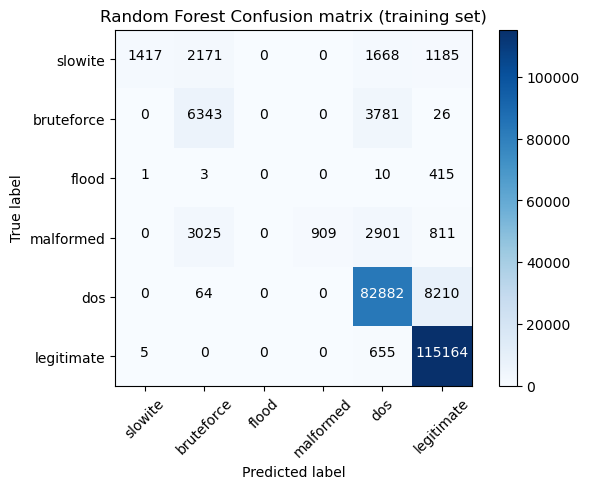

Test Accuracy: 88.35%


Test Precision: 88.87%
Test Recall: 88.35%
Test F1-Score: 0.87


Confusion matrix, without normalization
[[  452   942     0     0   624   743]
 [    0  2629     0     5  1654    63]
 [    0     2     0     0     0   182]
 [    0  1320     0   404  1240   314]
 [    0    29     0     0 34868  4180]
 [    2     0     0     0   265 49372]]


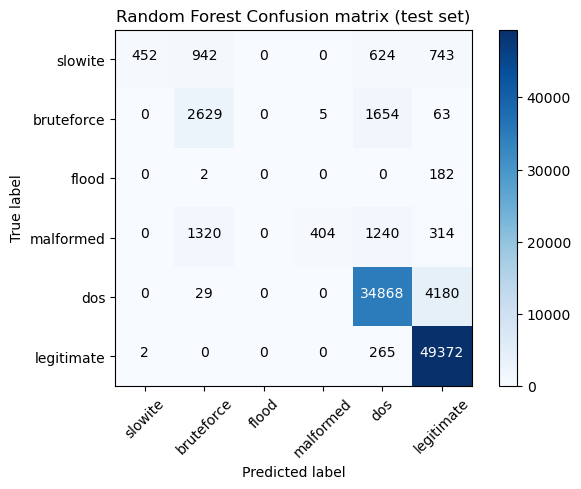

In [10]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(mqtt_train_df)
model_performance(model=rf_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Random Forest')

### Decision Tree (UnTuned)

Training Accuracy: 89.66%


Training Precision: 90.29%
Training Recall: 89.66%
Training F1-Score: 0.89


Confusion matrix, without normalization
[[   818   4177      0    207     39   1200]
 [   583   8507      0    284    747     29]
 [     1      7    208      2      5    206]
 [   381   4355      1   1755    525    629]
 [     0   1384      0     25  81159   8588]
 [     0    107      0      5    459 115253]]


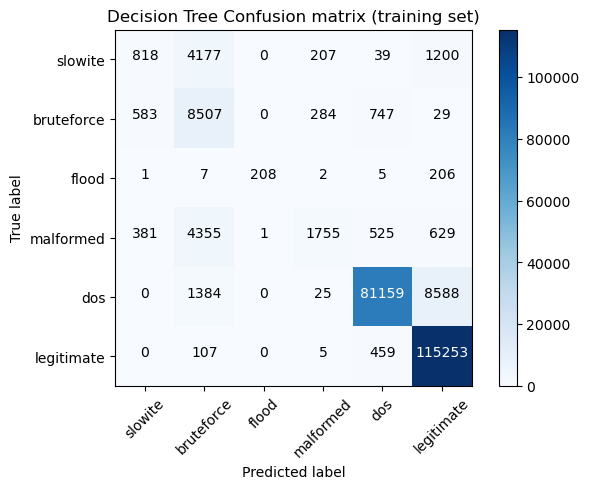

Test Accuracy: 88.95%


Test Precision: 88.69%
Test Recall: 88.95%
Test F1-Score: 0.88
Confusion matrix, without normalization
[[   79  1814     0    74    35   759]
 [  220  3569     0   165   385    12]
 [    0     2    87     2     0    93]
 [  205  1865     1   762   198   247]
 [    5   373     0     2 34408  4289]
 [    0    49     0     2   176 49412]]


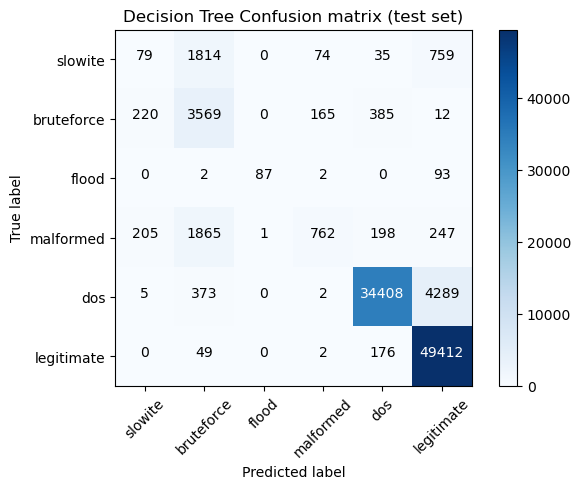

In [11]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dt_model = dt.fit(mqtt_train_df)
model_performance(model=dt_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Decision Tree')

## Tuning (The parameter have been reduced just for demo purposes --- actual tuning can be found on other notebooks)

### Random Forest

Tunable Parameters:
1. maxDepth : Maximum depth of each decision tree.
2. numTrees: Number of trees in forest.

In [12]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

rf_paramGrid = (ParamGridBuilder() \
    .addGrid(rf.maxDepth, [25]) \
    .build())

rf_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
rf_cv = CrossValidator(estimator = rf, estimatorParamMaps = rf_paramGrid, evaluator = rf_evaluator, numFolds = 3)

In [13]:
rf_cv_model = rf_cv.fit(mqtt_train_df)

Training Accuracy: 90.67%


Training Precision: 90.81%
Training Recall: 90.67%
Training F1-Score: 0.9


Confusion matrix, without normalization
[[  2657    959      0     59   1581   1185]
 [     1   6283      0     59   3781     26]
 [     2      2    138      0     10    277]
 [     8   2002      0   2907   2016    713]
 [     0     62      0      2  82882   8210]
 [     0      0      0      0    655 115169]]


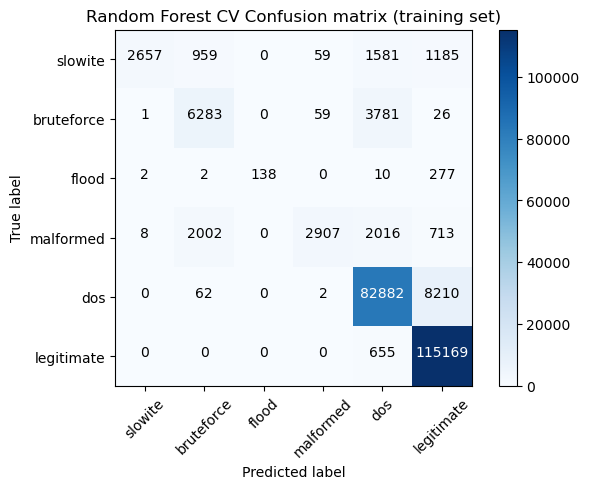

Test Accuracy: 90.04%


Test Precision: 90.05%
Test Recall: 90.04%
Test F1-Score: 0.89


Confusion matrix, without normalization
[[ 1238   123     0    84   579   737]
 [    0  2562     0    73  1653    63]
 [    0     2    60     0     0   122]
 [    4   854     0  1302   841   277]
 [    0    27     0     2 34868  4180]
 [    0     0     0     0   265 49374]]


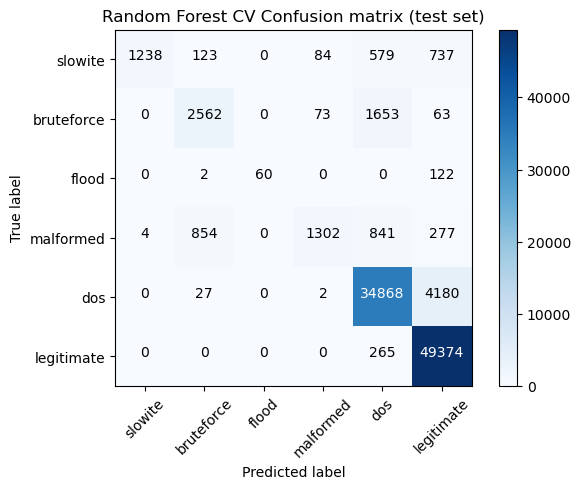

In [14]:
model_performance(model=rf_cv_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Random Forest CV')

### Decision Tree

Tunable Parameters:
1. maxDepth: Maximum depth of the tree
2. maxBins: Number of bins for splitting continous features.
3. minInstancesPerNode: Min number of instances a child must collect before splitting

In [15]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')

dt_paramGrid = (ParamGridBuilder() \
    .addGrid(dt.maxDepth, [15]) \
    .build())

dt_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
dt_cv = CrossValidator(estimator = dt, estimatorParamMaps = dt_paramGrid, evaluator = dt_evaluator, numFolds = 3)

In [16]:
dt_cv_model = dt_cv.fit(mqtt_train_df)

23/11/16 19:22:13 WARN YarnAllocator: Container from a bad node: container_1700160326367_0002_01_000001 on host: cluster-9596-m.us-central1-f.c.sturdy-spark-397520.internal. Exit status: 137. Diagnostics: [2023-11-16 19:22:13.574]Container killed on request. Exit code is 137
[2023-11-16 19:22:13.574]Container exited with a non-zero exit code 137. 
[2023-11-16 19:22:13.575]Killed by external signal
.
23/11/16 19:22:13 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container from a bad node: container_1700160326367_0002_01_000001 on host: cluster-9596-m.us-central1-f.c.sturdy-spark-397520.internal. Exit status: 137. Diagnostics: [2023-11-16 19:22:13.574]Container killed on request. Exit code is 137
[2023-11-16 19:22:13.574]Container exited with a non-zero exit code 137. 
[2023-11-16 19:22:13.575]Killed by external signal
.
23/11/16 19:22:13 ERROR YarnScheduler: Lost executor 1 on cluster-9596-m.us-central1-f.c.sturdy-spark-397520.intern

Training Accuracy: 92.33%


Training Precision: 92.62%
Training Recall: 92.33%
Training F1-Score: 0.92


Confusion matrix, without normalization
[[  3755   1293      0    154    261    978]
 [   109   8633      0    632    757     19]
 [     7      1    212      0     56    153]
 [   171   2415      0   4231    526    303]
 [   354    959      0     59  82540   7244]
 [   106      1      0      1   1214 114502]]


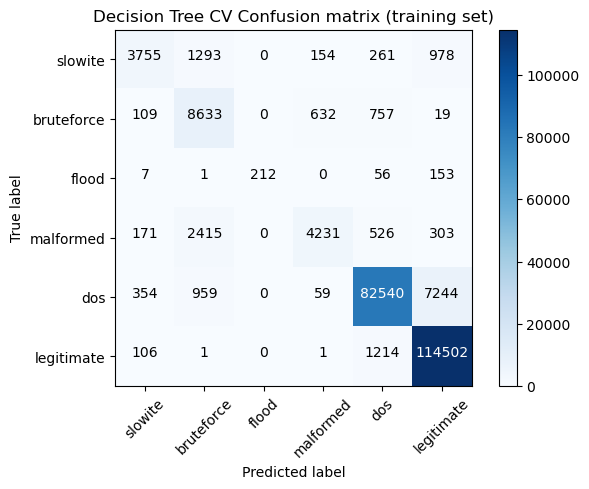

Test Accuracy: 91.78%


Test Precision: 91.83%
Test Recall: 91.78%
Test F1-Score: 0.92
Confusion matrix, without normalization
[[ 1579   198     0   190   171   623]
 [   98  3367     0   491   387     8]
 [    0     1    90     1    21    71]
 [   61  1048     1  1841   203   124]
 [   82   274     0    24 35174  3523]
 [   49     0     0     1   507 49082]]


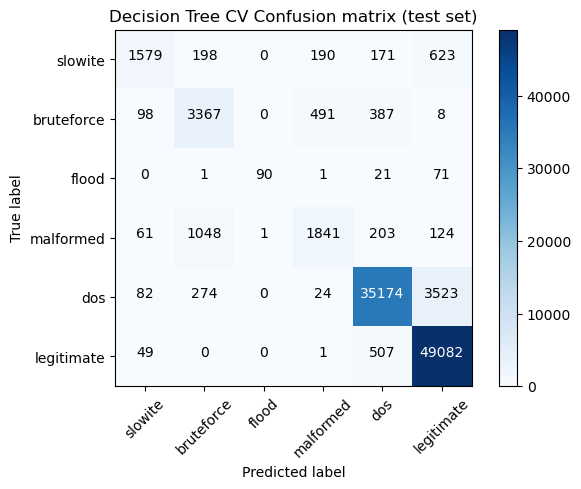

In [17]:
model_performance(model=dt_cv_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Decision Tree CV')